In [4]:
structure = [['Make an Environment'],
             ['Restudy DQL part'],
             ['Make your own similar environment for logistics in 2D'],
             ['Deploy DQL']]

steps = [['for (Place a loop for object something like random.index())'], 
                       ['random object selection'], 
                       ['Drop it inside the truck (Update object coordinates)'],
                       ['Press Enter']]

requirements = [['Objects can move using right & left keys'],
                 ['Objects can move through each other outside of the truck but not inside'],
                 ['Objects can move through walls but not blocks inside the truck'],
                 ['*If constraints are violated game is over'],
                 ['*Main goal is to fill in as much space as possible inside the truck'],
                 ['If ENTER is pressed after one object is inside the truck, next object gets into action'],
                 ['If ENTER is pressed when object is outside of the box, game is over'],
                 ['If SHIFT is pressed object will move horizontally rotate at 45 degrees']]

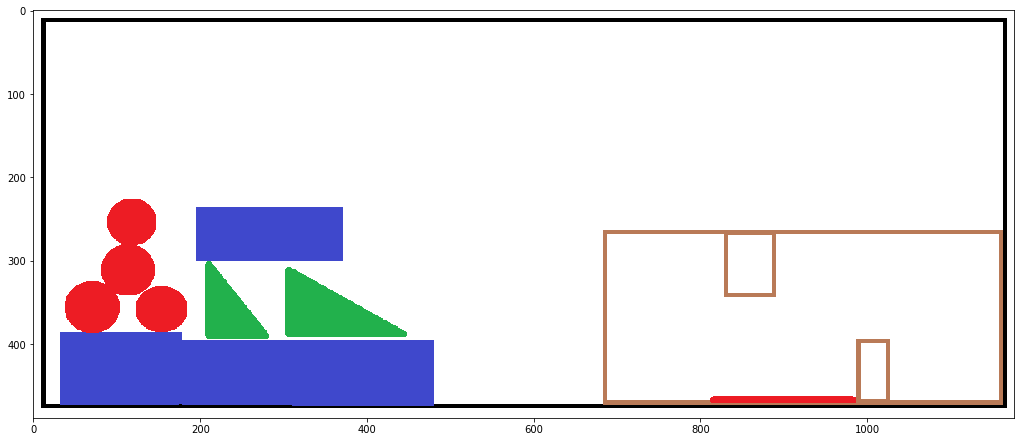

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open("LogisticsEnv.png")
plt.figure(figsize=(18,7.5))
plt.imshow(image)

In [8]:
image.size

(1177, 489)

In [1]:
import pygame
import random
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# window size
WIDTH = 360
HEIGHT = 360
FPS = 30 # how fast game is

# colors
WHITE = (255,255,255)
BLACK = (0,0,0)
RED = (255, 0, 0) # RGB
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)

class Player(pygame.sprite.Sprite):
    # sprite for the player
    def __init__(self):
        pygame.sprite.Sprite.__init__(self)
        self.image = pygame.Surface((20,20))
        self.image.fill(BLUE)
        self.rect = self.image.get_rect()
        self.radius = 10
        pygame.draw.circle(self.image, RED, self.rect.center,self.radius)
        self.rect.centerx = WIDTH/2
        self.rect.bottom = HEIGHT - 1
        self.speedx = 0
        
    def update(self, action):
        self.speedx = 0
        keystate = pygame.key.get_pressed()
        
        if keystate[pygame.K_LEFT] or action == 0:
            self.speedx = -4
        elif keystate[pygame.K_RIGHT] or action == 1:
            self.speedx = 4
        else:
            self.speedx = 0
         
        self.rect.x +=self.speedx
        
        if self.rect.right > WIDTH:
            self.rect.right = WIDTH
        if self.rect.left < 0:
            self.rect.left = 0
            
    def getCoordinates(self):
        return (self.rect.x, self.rect.y)   
    
class Enemy(pygame.sprite.Sprite):
    
    def __init__(self):
        pygame.sprite.Sprite.__init__(self)
        self.image = pygame.Surface((10,10))
        self.image.fill(RED)
        self.rect = self.image.get_rect()
        self.radius = 5
        pygame.draw.circle(self.image, WHITE, self.rect.center,self.radius)
        self.rect.x = random.randrange(0, WIDTH - self.rect.width)
        self.rect.y = random.randrange(2,6)
        
        self.speedx = 0
        self.speedy = 3
    
    def update(self):
        
        self.rect.x += self.speedx
        self.rect.y += self.speedy
        
        if self.rect.top > HEIGHT + 10:
            self.rect.x = random.randrange(0, WIDTH - self.rect.width)
            self.rect.y = random.randrange(2,6)
            self.speedy = 3
            
    def getCoordinates(self):
        return (self.rect.x, self.rect.y)  

class DQLAgent:
    def __init__(self):
        # parameter / hyperparameter
        self.state_size = 4 # distance [(playerx-m1x),(playery-m1y),(playerx-m2x),(playery-m2y)]
        self.action_size = 3 # right, left, no move 
        
        self.gamma = 0.95
        self.learning_rate = 0.001 
        
        self.epsilon = 1  # explore
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        
        self.memory = deque(maxlen = 1000)
        
        self.model = self.build_model()
        
        
    def build_model(self):
        # neural network for deep q learning
        model = Sequential()
        model.add(Dense(48, input_dim = self.state_size, activation = "relu"))
        model.add(Dense(self.action_size,activation = "linear"))
        model.compile(loss = "mse", optimizer = Adam(lr = self.learning_rate))
        return model
    
    def remember(self, state, action, reward, next_state, done):
        # storage
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        state = np.array(state)
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])
    
    def replay(self, batch_size):
        # training
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory,batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = np.array(state)
            next_state = np.array(next_state)
            if done:
                target = reward 
            else:
                target = reward + self.gamma*np.amax(self.model.predict(next_state)[0])
            train_target = self.model.predict(state)
            train_target[0][action] = target
            self.model.fit(state,train_target, verbose = 0)
            
    def adaptiveEGreedy(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
 
class Env(pygame.sprite.Sprite):
   
    def __init__(self):
        pygame.sprite.Sprite.__init__(self)
        self.all_sprite = pygame.sprite.Group()
        self.enemy = pygame.sprite.Group()
        self.player = Player()
        self.all_sprite.add(self.player)
        self.m1 = Enemy()
        self.m2 = Enemy()
        self.all_sprite.add(self.m1)
        self.all_sprite.add(self.m2)
        self.enemy.add(self.m1)
        self.enemy.add(self.m2)
        
        self.reward = 0
        self.total_reward = 0
        self.done = False
        self.agent = DQLAgent()
        
    def findDistance(self, a, b):
        d = a-b
        return d
    
    def step(self, action):
        state_list = []
        
        # update
        self.player.update(action)
        self.enemy.update()
        
        # get coordinate
        next_player_state = self.player.getCoordinates()
        next_m1_state = self.m1.getCoordinates()
        next_m2_state = self.m2.getCoordinates()
        
        # find distance
        state_list.append(self.findDistance(next_player_state[0],next_m1_state[0]))
        state_list.append(self.findDistance(next_player_state[1],next_m1_state[1]))
        state_list.append(self.findDistance(next_player_state[0],next_m2_state[0]))
        state_list.append(self.findDistance(next_player_state[1],next_m2_state[1]))
        
        return [state_list]
         
    # reset
    def initialStates(self):
        self.all_sprite = pygame.sprite.Group()
        self.enemy = pygame.sprite.Group()
        self.player = Player()
        self.all_sprite.add(self.player)
        self.m1 = Enemy()
        self.m2 = Enemy()
        self.all_sprite.add(self.m1)
        self.all_sprite.add(self.m2)
        self.enemy.add(self.m1)
        self.enemy.add(self.m2)
        
        self.reward = 0
        self.total_reward = 0
        self.done = False
    
        state_list = []
        
        # get coordinate
        player_state = self.player.getCoordinates()
        m1_state = self.m1.getCoordinates()
        m2_state = self.m2.getCoordinates()
        
        # find distance
        state_list.append(self.findDistance(player_state[0],m1_state[0]))
        state_list.append(self.findDistance(player_state[1],m1_state[1]))
        state_list.append(self.findDistance(player_state[0],m2_state[0]))
        state_list.append(self.findDistance(player_state[1],m2_state[1]))
        
        return [state_list]
        
    def run(self):
        # game loop
        state = self.initialStates()
        running = True
        batch_size = 24
        while running:
            self.reward = 2
            # keep loop running at the right speed
            clock.tick(FPS) 
            # process input
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False   
            # update
            action = self.agent.act(state)
            next_state = self.step(action)
            self.total_reward += self.reward 
                
            hits = pygame.sprite.spritecollide(self.player,self.enemy,False, pygame.sprite.collide_circle)   
            if hits:
                self.reward = -150
                self.total_reward += self.reward 
                self.done = True
                running = False
                print("Total reward: ",self.total_reward) 
            
            # storage
            self.agent.remember(state, action,self.reward, next_state, self.done)
            
            # update state
            state = next_state
            
            # training
            self.agent.replay(batch_size)
            
            # epsilon greedy
            self.agent.adaptiveEGreedy()
            
            # draw / render(show)
            screen.fill(GREEN)
            self.all_sprite.draw(screen)
            # after drawing flip display
            pygame.display.flip()
    
        pygame.quit()  

if __name__ == "__main__":
    env = Env()
    liste = []
    t = 0
    while True:
        t += 1
        print("Episode: ",t)
        liste.append(env.total_reward)
                
        # initialize pygame and create window
        pygame.init()
        screen = pygame.display.set_mode((WIDTH,HEIGHT))
        pygame.display.set_caption("RL Game")
        clock = pygame.time.Clock()
        
        env.run()

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
